<center> <h1> Language Models </h1> </center>

In this homework, we will train character-level language model
on a lyrics dataset.

More specifically, we will:
1. Implement a character-level language model based on LSTM.
2. Train it on a lyrics dataset.
3. Sample previously unseen lyrics from our model.
4. Augment our model with an artist information.

#### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people. In this homework, we will ask you to copy current colaboraty,
complete all the tasks and share your colaboratory notebook with us so
that we can grade it. We will also use colaboratory for the homework #4 so this
homework will prepare you for it.

#### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write/change/uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected.
5. Paste the link into your submission pdf file so that we can view it and grade.

<center> <h2> Problem statement </h2> </center>

In this homework we will train character-level language RNN model on lyrics dataset of most some artists. Having a trained model, we will sample a couple of songs which will be a mixture of different styles of different artists. After that we will update our model to become a conditional character-level RNN, making it possible for us to sample songs conditioned on artist.

<center> <h2> Lyrics dataset </h2> </center>

For our experiments we will use a subset of [Song Lyrics Kaggle dataset](https://www.kaggle.com/mousehead/songlyrics) which contains good variety of recent artists and more older ones. It is stored as a pandas file and we wrote a python wrapper around it to be able to use it for training purposes.

<center> <h2> Character-Level language model </h2> </center>

![alt text](http://warmspringwinds.github.io/assets/img/character_level_model.jpg "Logo Title Text 1")

Before choosing a model, let’s have a closer look at our task. Given current letter and all previous letters, we will try to predict the next character. During training we will just take a sequence, and use all its characters except the last one as an input and the same sequence starting from the second character as groundtruth (see the picture above; Source).

Our language model is defined on a character level. We will create a dictionary which will contain all English characters plus some special symbols, like period, comma, and end-of-line symbol. Each charecter will be represented as one-hot-encoded tensor. For more information about character-level models and examples, refer to the [the following resource](https://github.com/spro/practical-pytorch)


Having characters, we can now form sequences of characters. What we would actually like to model is $p(current letter|all previous letters)$. At first, the task seems intractable as the number of previous letters is variable and it might become really large in case of long sequences. Turns out Reccurent Neural Netoworks can tackle this problem to a certain extent by using shared weights and fixed size hidden state. This leads us to a next section dedicated to RNNs.

<center> <h2> Recurrent Neural Networks </h2> </center>

![alt text](http://warmspringwinds.github.io/assets/img/rnn_unfold.jpg "Logo Title Text 1")

Recurrent neural networks are a family of neural networks for processing sequential data. Unlike feedforward neural networks, RNNs can use their internal memory to process arbitrary sequences of inputs. Because of arbitrary size input sequences, they are concisely depicted as a graph with a cycle (see the picture; Source). But they can be “unfolded” if the size of input sequence is known. They define a non-linear mapping from a current input xt and previous hidden state st−1 to the output ot and current hidden state st. Hidden state size has a predefined size and stores features which are updated on each step and affect the result of mapping.

Now align the previous picture of the character-level language model and the unfolded RNN picture to see how we are using the RNN model to learn a character level language model.

While the picture depicts the Vanilla RNN, we will use LSTM in our work as it is easier to train usually achieves better results.

For a more elaborate introduction to RNNs, we refer reader to [the following resource](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/).

<center> <h2> Training unconditional character-level language model </h2> </center>

Our first experiment consisted of training of our character-level language model RNN on the whole corpus. We didn’t take into consideration the artist information while training.

In [0]:
# Downloading dataset and installing dependencies
!wget https://www.dropbox.com/s/ge1bhvik5jya9hr/songdata.csv?dl=0
!mv songdata.csv\?dl\=0 songdata.csv
!pip install livelossplot==0.3.4

First, let us create a dictionary, we will use $100$ characters and some special symbols including $\n$ which will allow our generator to also decide when the current line should end.

In [0]:
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.data as data


all_characters = string.printable
number_of_characters = len(all_characters)

print(all_characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



Below we will define some helper functions that will help us to convert character to corresponding
labels that we will use for actual training.

In [0]:
def character_to_label(character):
    
    character_label = all_characters.find(character)
        
    return character_label


def string_to_labels(character_string):
    
    return list(map(lambda character: character_to_label(character), character_string))

  
def pad_sequence(seq, max_length, pad_label=100):
    
    seq += [pad_label for i in range(max_length - len(seq))]
    
    return seq

Now we will define a dataset class that will take care of loading data from the dataset

In [0]:

# The class works in two modes: train and validation, which we will
# use during training

# It also padds data so that all sequences are of the same length.
# We need this because otherwise efficient batching will not work
# and we will not be able to use GPU processing to the full extent
class LyricsGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path,
                 minimum_song_count=None,
                 artists=None,
                 train=True):
        
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:
            
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
        
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        
        whole_dataset_len = len(self.lyrics_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        if train:
          
          self.indexes = self.indexes[500:]
          
        else:
          self.indexes = self.indexes[:500]
        
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        
        self.number_of_artists = len(self.artists_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        # Filling in sequences with a '-100' lable -- this way it is omitted
        # in cross_entropy_loss
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_length]) )

# Here are the artists
artists = [
'ABBA',
'Ace Of Base',
'Backstreet Boys',
'Bob Marley',
'Bon Jovi',
'Britney Spears',
'Bruno Mars',
'Coldplay',
'Ed Sheeran',
'Elton John',
'Elvis Presley',
'Eminem',
'Evanescence',
'Fall Out Boy',
'Foo Fighters',
'Green Day',
'HIM',
'Imagine Dragons',
'Justin Bieber',
'Justin Timberlake',
'Katy Perry',
'Lady Gaga',
'Lana Del Rey',
'Linkin Park',
'Madonna',
'Marilyn Manson',
'Maroon 5',
'Metallica',
'Michael Jackson',
'Nickelback',
'Oasis',
'One Direction',
'P!nk',
'Queen',
'Red Hot Chili Peppers',
'Rihanna',
'Robbie Williams',
'Sting',
'The Script',
'Weezer',
'Yellowcard']

trainset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists)
valset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists, train=False)



In [0]:
# Let us inspect the dataset quickly
trainset.lyrics_dataframe

,index,artist,song,link,text
0,0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
5,5,ABBA,Burning My Bridges,/a/abba/burning+my+bridges_20003011.html,"Well, you hoot and you holler and you make me ..."
6,6,ABBA,Cassandra,/a/abba/cassandra_20002811.html,Down in the street they're all singing and sho...
7,7,ABBA,Chiquitita,/a/abba/chiquitita_20002978.html,"Chiquitita, tell me what's wrong \nYou're enc..."
8,8,ABBA,Crazy World,/a/abba/crazy+world_20003013.html,I was out with the morning sun \nCouldn't sle...
9,9,ABBA,Crying Over You,/a/abba/crying+over+you_20177611.html,I'm waitin' for you baby \nI'm sitting all al...


In [0]:
len(trainset)

4298

In [0]:
len(valset)

500

Below, we are defining an RNN class, and will ask you to feel out missing parts.

In [0]:
class RNN(nn.Module):
    
    def __init__(self,
                 input_size=101,
                 hidden_size=512,
                 num_classes=100,
                 n_layers=2):
        
        # input_size = 101 -- 100 characters + background character
        # num_classes = 100 -- we predict what character goes next
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        
        # Below use nn.Embedding to map from input_size to hidden_size
        # nn.Embedding converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        self.embedder = # TODO
        
        # Below use nn.LSTM that accepts hidden_size as input size,
        # and has hidden size equal to hidden_size argument and
        # n_layers
        self.lstm = # TODO
        
        # Below use nn.Linear to make representation of hidden_size
        # to the number of classes that will be fed to softmax
        # to decide which character goes next
        self.logits_fc = # TODO
    
    
    def forward(self,
                input_sequences,
                input_sequences_lengths,
                hidden=None):
        
        batch_size = input_sequences.shape[1]

        embedded = self.embedder(input_sequences)
        
        # This is needed for efficient processing of sequences of
        # variable lengths. Feel free to skip
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        
        logits = self.logits_fc(outputs)
        # This is needed for cross entropy loss
        logits = logits.transpose(0, 1).contiguous()
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden

# for efficient processing of sequences of
# variable lengths. Feel free to skip 
def post_process_sequence_batch(batch_tuple):
  
  input_sequences, output_sequences, lengths = batch_tuple

  splitted_input_sequence_batch = input_sequences.split(split_size=1)
  splitted_output_sequence_batch = output_sequences.split(split_size=1)
  splitted_lengths_batch = lengths.split(split_size=1)

  training_data_tuples = zip(splitted_input_sequence_batch,
                             splitted_output_sequence_batch,
                             splitted_lengths_batch)

  training_data_tuples_sorted = sorted(training_data_tuples,
                                       key=lambda p: int(p[2]),
                                       reverse=True)

  splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

  input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
  output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
  lengths_batch_sorted = torch.cat(splitted_lengths_batch)

  input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
  output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]

  input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)

  # pytorch's api for rnns wants lenghts to be list of ints
  lengths_batch_sorted_list = list(lengths_batch_sorted)
  lengths_batch_sorted_list = list(map(lambda x: int(x), lengths_batch_sorted_list))


  return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list

In [0]:
trainset_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=50,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True)


valset_loader = torch.utils.data.DataLoader(valset,
                                            batch_size=50,
                                            shuffle=True,
                                            num_workers=1,
                                            drop_last=True)


rnn = RNN(input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters))
rnn.cuda()

#TODO? Try different learning rates and optimizers
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [0]:
from livelossplot import PlotLosses

liveloss = PlotLosses()

# We will get back to this function later on,
# Just ignore it so far -- we will use it to generate
# samples during our training
def sample_from_rnn(starting_string="I", sample_length=300, temperature=0.5):
    assert temperature >= 0.0
    sampled_string = starting_string
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_string) ).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = first_input

    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in range(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature + 1e-4) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]

        current_input = predicted_label.unsqueeze(1)

        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string

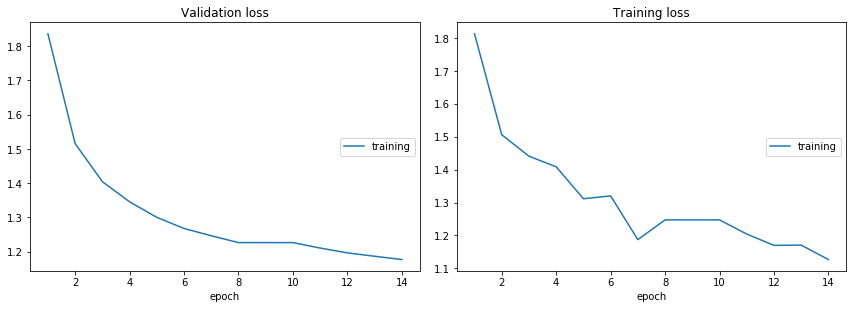

Validation loss:
training   (min:    1.177, max:    1.836, cur:    1.177)

Training loss:
training   (min:    1.127, max:    1.813, cur:    1.127)
Example of a text generated by current model:
I feel it to go  
I don't want to do what I wish  
And I want to get it all  
Then I want to say  
I think you've got a better thing  
  
I want you to make it was been through  
I know I can do it  
You were the stars  
The walls and funky or a tears  
  
It's all alone  
Don't you know you're the o


In [0]:
epochs_number = 8


for epoch_number in range(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
        input_sequences_batch_var = input_sequences_batch.cuda()
        
        optimizer.zero_grad()
        
        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        
        
        train_loss = criterion(logits, output_sequences_batch_var)
        
        train_loss.backward()
        
        optimizer.step()
    
    
    val_loss_list = []
    
    with torch.no_grad():
      
      for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
        input_sequences_batch_var = input_sequences_batch.cuda()
        
        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        loss = criterion(logits, output_sequences_batch_var)
        
        val_loss_list.append(loss.item())
      
    liveloss.update({'Validation loss': sum(val_loss_list) / len(val_loss_list),
                     'Training loss': train_loss.item()})
    liveloss.draw()
    
    print('Example of a text generated by current model:')
    print(sample_from_rnn(starting_string='I', temperature=0.5))
    
    
    

<center> <h2> Text Generation </h2> </center>

During the text generation process we can define a starting prefix of characters that our model will condition on and generate the rest of the sequence. 

The model generates each new token (characters in our case) by sampling from the output probability distribution. When sampling, we can set a `temperature` parameter that controls the randomness of the sampling process. When this parameter approaches zero, the sampling is equivalent to argmax and when it is close to infinity the sampling is equivalent to sampling from a uniform distribution.

In [0]:
def sample_from_rnn(starting_string="Why", sample_length=300, temperature=1):
    assert temperature >= 0.0
    sampled_string = starting_string
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_string) ).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = first_input

    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in range(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature + 1e-4) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]

        current_input = predicted_label.unsqueeze(1)

        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string

#TODO? Try sampling with different temperatures and starting sequences
# What do you observe? (See the pdf)
print(sample_from_rnn(starting_string='I', temperature=0.5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


I can't say to shadow  
  
I can't show you that I have to fight  
The one that I was no right  
I can't feel the sun  
I am a dance  
I still walk to me  
I'm a little boy  
I don't want you  
I want me for me  
I want it be love  
I need you this love  
I don't know what I love you  
I wanna say I 


<center> <h2> Conditional Model (Optional) </h2> </center>
So far our RNN has been trained on lyrics from all the songs without knowledge of which artists.

Next, we will give the RNN additional information, the class representing the artist who made the song.

Below we provide updated functions and dataset class that can be used to train language model that is conditioned on the artist.

In [0]:
class LyricsGenerationDatasetConditional(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_song_count=None, artists=None):
        
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:
            
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
        
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        
        whole_dataset_len = len(self.lyrics_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        
        # Let's get unique artists and form a list
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        
        # We will need the overall number of artists for 
        self.number_of_artists = len(self.artists_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        ## Adding the artist label
        sequence_raw_artist_name_string = self.lyrics_dataframe.loc[index].artist

        sequence_artist_label = self.artists_list.index(sequence_raw_artist_name_string)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_artist_label]),
                torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch_conditional(batch_tuple):
    
    input_sequences, output_sequences, artists, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_artists_batch = artists.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_artists_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[3]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_artists_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    artists_batch_sorted = torch.cat(splitted_artists_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    
    # We should probably repeat this over the whole input sequence
    artists_batch_sorted = artists_batch_sorted.expand_as(input_sequence_batch_sorted)

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    artists_batch_sorted_transposed = artists_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = list(map(lambda x: int(x), lengths_batch_sorted_list))
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, artists_batch_sorted_transposed, lengths_batch_sorted_list


class RNN_Conditional(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, num_conditions, n_layers=2):
        
        super(RNN_Conditional, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.num_conditions = num_conditions
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        
        
        self.characters_embedder = # TODO: complete this line
        
        self.artist_embedder = # TODO: complete this line
        
        self.lstm = nn.LSTM(hidden_size * 2, #, #) # TODO: complete this line
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_conditions, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        characters_embedded = self.characters_embedder(input_sequences)
        conditions_embedded = self.artist_embedder(input_sequences_conditions)
        
        embedded_combined = torch.cat((characters_embedded, conditions_embedded), dim=2)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded_combined, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden



In [0]:
def sample_from_rnn_conditionally(starting_string="Why", sample_length=300, temperature=1, artist_label=0):
    
    sampled_string = starting_string
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_string) ).cuda()
    first_input = first_input.unsqueeze(1)

    # Expand the artist label to have the same size as input sequence
    # we duplicate it in every input
    artist_label_input = torch.LongTensor([artist_label]).expand_as(first_input)

    current_sequence_input = first_input
    current_artist_input = artist_label_input.cuda()

    output, hidden = rnn(current_sequence_input, current_artist_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in range(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]
        current_sequence_input = predicted_label.unsqueeze(1)

        artist_label_input = torch.LongTensor([artist_label]).expand_as(current_sequence_input)
        current_artist_input = artist_label_input.cuda()

        output, hidden = rnn(current_sequence_input, current_artist_input, [1], hidden=hidden)
    
    return sampled_string

In [0]:
trainset = LyricsGenerationDatasetConditional(csv_file_path='songdata.csv', artists=artists)

trainset_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)

In [0]:
rnn = RNN_Conditional(input_size=len(all_characters) + 1,
          hidden_size=512,
          num_classes=len(all_characters),
          num_conditions=trainset.number_of_artists)

rnn.cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [0]:
from livelossplot import PlotLosses

liveloss_train = PlotLosses()
liveloss_val = PlotLosses()

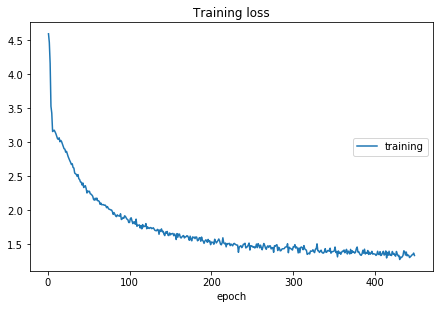

Training loss:
training   (min:    1.273, max:    4.598, cur:    1.332)


KeyboardInterrupt: ignored

In [0]:
# Conditional model takes more to converge,
# Try training for more epochs for better results
epochs_number = 5000

for epoch_number in range(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch_conditional(batch)

        input_sequences_batch, output_sequences_batch, artists_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var = output_sequences_batch.contiguous().view(-1).cuda()
        
        
        input_sequences_batch_var = input_sequences_batch.cuda()
        artists_batch_var = artists_batch.cuda()
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, artists_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss.backward()
        
        liveloss_train.update({'Training loss': loss.item()})
        liveloss_train.draw()

        #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
        
    #print(sample_from_rnn_conditionally(artist_label=trainset.artists_list.index("Kanye West")))
    torch.save(rnn.state_dict(), 'conditional_rnn.pth')

In [0]:
print(sample_from_rnn_conditionally(artist_label=trainset.artists_list.index("Eminem"), starting_sting='A', temperature=0.5))